In [179]:
from collections import defaultdict
import pyspark
from pyspark.sql import SparkSession
import pyspark.pandas as ps
from pyspark.sql.functions import split, col
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt

sc = (
    SparkSession
    .builder
    .master("local[2]")
    .appName("hw05")
    .getOrCreate()
)


In [209]:
dtrain = (
    sc
    .read
    .format("csv")
    .option("header",True)
    .option("quote", "\"")
    .option("escape", "\"")
    .option("multiline", True)
    .load("file:///home/jovyan/work/train.csv")
    .withColumn("toxic",col("toxic").cast("integer"))
    .withColumn("severe_toxic",col("severe_toxic").cast("integer"))
    .withColumn("obscene",col("obscene").cast("integer"))
    .withColumn("threat",col("threat").cast("integer"))
    .withColumn("insult",col("insult").cast("integer"))
    .withColumn("identity_hate",col("identity_hate").cast("integer"))
)


dtest = (
    sc
    .read
    .format("csv")
    .option("header",True)
    .option("quote", "\"")
    .option("escape", "\"")
    .option("multiline", True)
    .load("file:///home/jovyan/work/test.csv")
    # .withColumn("toxic",col("toxic").cast("integer"))
    # .withColumn("severe_toxic",col("severe_toxic").cast("integer"))
    # .withColumn("obscene",col("obscene").cast("integer"))
    # .withColumn("threat",col("threat").cast("integer"))
    # .withColumn("insult",col("insult").cast("integer"))
    # .withColumn("identity_hate",col("identity_hate").cast("integer"))
)

dlabels = (
    sc
    .read
    .format("csv")
    .option("header",True)
    .load("file:///home/jovyan/work/test_labels.csv")
    .withColumn("toxic",col("toxic").cast("integer"))
    .withColumn("severe_toxic",col("severe_toxic").cast("integer"))
    .withColumn("obscene",col("obscene").cast("integer"))
    .withColumn("threat",col("threat").cast("integer"))
    .withColumn("insult",col("insult").cast("integer"))
    .withColumn("identity_hate",col("identity_hate").cast("integer"))
)

dtest = dtest.join(dlabels, "id")

targets = [
    'toxic', 'severe_toxic', 'obscene',
    'threat', 'insult', 'identity_hate',
]

metrics = defaultdict(dict)
n_feats = 5
for n_feats in [50, 100, 150, 200, 250, 300, 350, 400]:
    tokenizer = Tokenizer(inputCol="comment_text", outputCol="comment_words")
    dtrain2 = tokenizer.transform(dtrain)
    # 1) Подготовить фичи комментариев с помощью HashingTF и IDF
    hashingTF = HashingTF(inputCol="comment_words", outputCol="feats_raw", numFeatures=n_feats)
    dtrain2 = hashingTF.transform(dtrain2)
    idf = IDF(inputCol="feats_raw", outputCol="feats")
    idfModel = idf.fit(dtrain2)
    dtrain2 = idfModel.transform(dtrain2)
    
    # 2) Обучить линейные классификаторы и сравнить метрики качества моделей
    for target in targets:
        lr = LogisticRegression(labelCol=target).setFeaturesCol("feats")
        lrn = lr.fit(dtrain2)
        dtest2 = dtest[dtest[target]!=-1]#.show(10)
        dtest2 = tokenizer.transform(dtest2)
        dtest2 = hashingTF.transform(dtest2)
        dtest2 = idfModel.transform(dtest2)
        dtest2 = lrn.transform(dtest2)
        bce = BinaryClassificationEvaluator(labelCol=target)
        auroc = bce.evaluate(dtest2)
        # 3) Сделать выводы о влиянии параметра numFeatures в HashingTF на качество метрик
        metrics[target][n_feats] = auroc
    print(f"n_feats={n_feats} done.")

n_feats=50 done.
n_feats=100 done.
n_feats=150 done.
n_feats=200 done.
n_feats=250 done.
n_feats=300 done.
n_feats=350 done.
n_feats=400 done.


In [210]:
metrics

defaultdict(dict,
            {'toxic': {50: 0.7023592610973597,
              100: 0.7588961337832818,
              150: 0.7730249869290667,
              200: 0.7894934848427088,
              250: 0.8088659185939483,
              300: 0.8086190529518069,
              350: 0.8167718411681788,
              400: 0.823557070116032},
             'severe_toxic': {50: 0.6982599277103055,
              100: 0.7761570379431182,
              150: 0.8414787992942603,
              200: 0.8389306349727805,
              250: 0.8493466140438014,
              300: 0.846914726117366,
              350: 0.8332044562237657,
              400: 0.8636157345500531},
             'obscene': {50: 0.7316303307725864,
              100: 0.7809359849868672,
              150: 0.8058619625369426,
              200: 0.8203611127388105,
              250: 0.8355624154643618,
              300: 0.8325331930620663,
              350: 0.8392413837042281,
              400: 0.843577043246092},
             

max=0.823557070116032


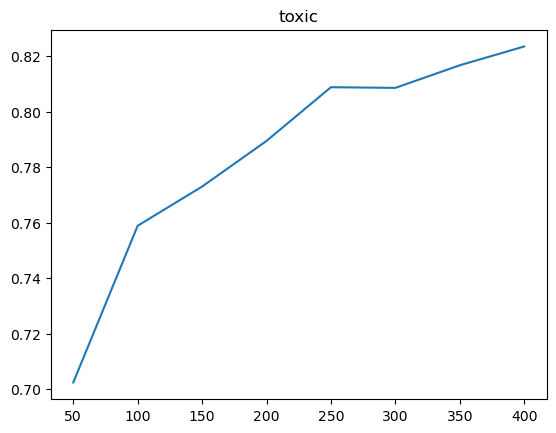

In [217]:
target = "toxic"
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.8636157345500531


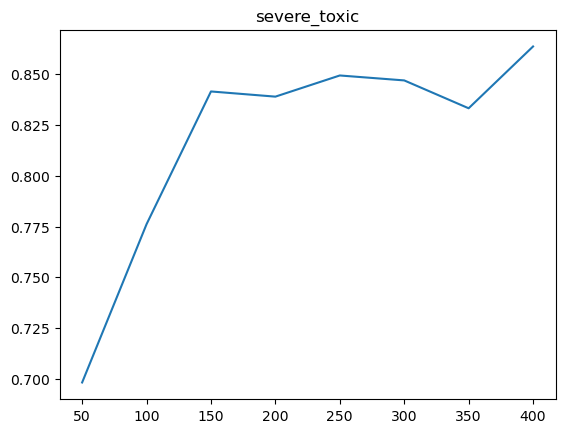

In [212]:
target = 'severe_toxic'# 'obscene', 'threat', 'insult', 'identity_hate',
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.843577043246092


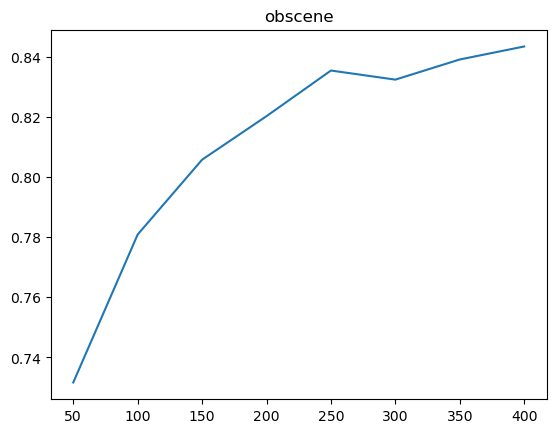

In [213]:
target = 'obscene'#, 'threat', 'insult', 'identity_hate',
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.9015211035258167


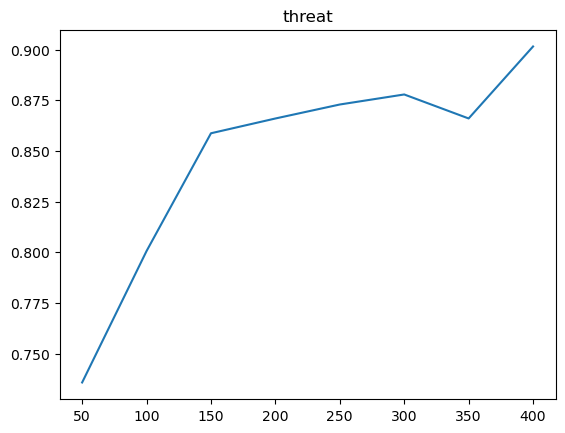

In [214]:
target = 'threat'#, 'insult', 'identity_hate',
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.8367414495952846


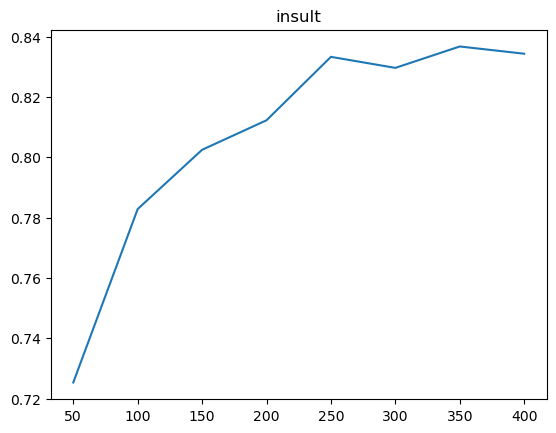

In [215]:
target = 'insult'#, 'identity_hate',
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.7959609386904639


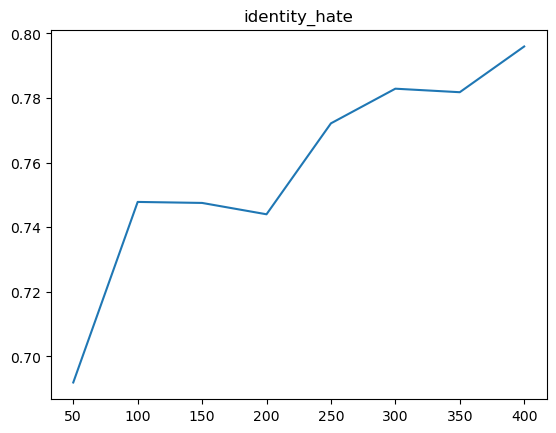

In [216]:
target = 'identity_hate'
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

# Выводы
1. Для каждого таргета метрика AUROC растет с увеличением numFeatures пока не достигнет оптимального значения numFeatures, затем падает. 
2. У каждого таргета свое оптимальное значение numFeatures